# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png)  Project 3: Web APIs & Classification
Reddit's API:  Data Wrangling, Natural Language Processing, and Classification Modeling


This project covers three of the biggest concepts in Data Science:
- Data Wrangling/Acquisition
- Natural Language Processing
- Classification Modeling

---
## Technical Report:   *SubReddit NLP & Random Forest Model*
This notebook --just one component of the overall project-- reflects Natural Language Processing (NLP) and classification modeling of the subreddit data scraped in Part 1.

The concatenated data can be referenced here:
- `SUBREDDITS.csv`: [concatenated: Nutrition & Medicine](../data/SUBREDDITS.csv)

Part 2 of the project focuses on Natural Language Processing and converting standard text data (like Titles and Comments) into a format that allows us to analyze it and use it in modeling.

Part 3 of the project focuses on Classification Modeling, preprocessing and evaluation.

The concatenated data will be used with NLP to train a classifier on which subreddit a given post came from. **This is a binary classification problem**. Within this notebook, a Random Forest model will be created.


## Import Required Python Libraries

In [1]:
# required for classification modeling and tuning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
# required for confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
# required to ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Python libraries used for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Create SUBREDDITS dataframe from .csv

In [4]:
!pwd

/Users/ngms/GA-DSI/SUBMISSIONS/Project_3/code


In [6]:
#load dataset into pandas dataframe (from data files)
subreddits = pd.read_csv('../data/SUBREDDITS.csv')

In [7]:
# look at positive class (nutrition)
subreddits.head()

,title,nutrition
0,Which one is better for taking for bodybuildin...,1
1,Using a blood sugar monitor to maximise fat loss?,1
2,Can you see if you are burning fat by doing bl...,1
3,You are supposed to eat tumric with black pepp...,1
4,How to encourage coworker to eat better?,1


In [8]:
# look at negative class (medicine)
subreddits.tail()

,title,nutrition
8178,Alternative to Language Lines?,0
8179,Normal saline vs lactated ringers in ambulator...,0
8180,Are there any major differences between Wester...,0
8181,"So, we met with the Patient Experience Coach t...",0
8182,Lead in potassium supplements?,0


In [9]:
# count number of observations in each class
# note:  classes are very unbalanced...
subreddits['nutrition'].value_counts()

1    6167
0    2016
Name: nutrition, dtype: int64

In [10]:
subreddits.isnull().sum()

title        0
nutrition    0
dtype: int64

In [11]:
subreddits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8183 entries, 0 to 8182
Data columns (total 2 columns):
title        8183 non-null object
nutrition    8183 non-null int64
dtypes: int64(1), object(1)
memory usage: 127.9+ KB


In [12]:
subreddits.groupby('nutrition').describe()

title                                                               
          count unique                                                top freq
nutrition                                                                     
0          2016   1989   [Weekly thread] Patients say the darndest things    5
1          6167   6134  Opinions on macronutrient ratios that aren't e...    2

## Pre-modeling steps
First create a test set before applying TFIDF transformer (or the IDF will be impacted by data from our test set)

In [14]:
# dropping the positive class...
X = subreddits.drop('nutrition', 1)  #predictor
y = subreddits['nutrition']  #prediction

In [16]:
# baseline accuracy
print('baseline accuracy: ', y.mean())
subreddits['nutrition'].value_counts(normalize=True)

baseline accuracy:  0.7536355859709153


1    0.753636
0    0.246364
Name: nutrition, dtype: float64

In [17]:
# creating a test set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=24)

**Instantiate a TFIDF vectorizer**

The TF-IDF vectorizer is a transformer. It transforms X data in a way better suited for modeling. Common words are penalized and rare words have more influence. "Stop words" can also be used with TF-IDF to improve modeling.

In [18]:
# max_df: Ignore words that occur in 95% of the documents from the corpus
# min_df: A word must occur in at least 5 documents from the corpus
tfidf = TfidfVectorizer(stop_words='english', max_df=.95, min_df=5)

Training:  **Create a corpus out of the list of titles. Fit and transform the vecotrizer on the corpus**

In [19]:
train_titles = tfidf.fit_transform(X_train['title'])

Training:  **Convert the vectorized data into a dataframe**

In [20]:
# use SparseDataFrame for space considerations
#1255 columns created...
train_df = pd.SparseDataFrame(train_titles, columns=tfidf.get_feature_names())

train_df.head()

,000,10,100,100g,12,15,16,17,18,19,...,writing,wrong,year,years,yeast,yoghurt,yogurt,young,zero,zinc
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's `fillna` with 0 (as all NaNs are just a result of the sparse representation).

In [21]:
train_df.fillna(0, inplace=True)

In [46]:
print(train_df.columns)

Index(['000', '10', '100', '100g', '12', '15', '16', '17', '18', '19',
       ...
       'writing', 'wrong', 'year', 'years', 'yeast', 'yoghurt', 'yogurt',
       'young', 'zero', 'zinc'],
      dtype='object', length=1255)


In [22]:
# check for missing values
train_df.isnull().sum()

000           0
10            0
100           0
100g          0
12            0
15            0
16            0
17            0
18            0
19            0
20            0
2000          0
2018          0
2019          0
21            0
22            0
23            0
24            0
25            0
26            0
27            0
28            0
30            0
31            0
50            0
80            0
90            0
able          0
absolutely    0
absorb        0
             ..
wheat         0
whey          0
white         0
winter        0
wise          0
wish          0
women         0
won           0
wondering     0
work          0
working       0
workout       0
workouts      0
works         0
world         0
worried       0
worry         0
worse         0
worst         0
worth         0
writing       0
wrong         0
year          0
years         0
yeast         0
yoghurt       0
yogurt        0
young         0
zero          0
zinc          0
Length: 1255, dtype: int

## Repeat steps for test data...

In [23]:
X_test.head()

,title
420,Anyone know if Coconut Flour cold cereal is OK...
4450,What are common foods that contain branched ch...
3021,"Galactose: Good, bad, or neither?"
415,Help with the veggiesss please!
6551,"Docs who do international work regularly, how ..."


In [24]:
# these are the same steps performed on training data above...
#1255 columns created...
test_titles = tfidf.transform(X_test['title'])
test_df = pd.SparseDataFrame(test_titles, columns=tfidf.get_feature_names())
test_df.fillna(0, inplace=True)
test_df.head()

,000,10,100,100g,12,15,16,17,18,19,...,writing,wrong,year,years,yeast,yoghurt,yogurt,young,zero,zinc
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Fit a Random Forest model using `nutrition` as the target

**Instantiate the GridSearchCV for RandomForestClassifier, fit and score on the train data**

We'll start with 100 estimators and just search over `min_samples_split`.

In [25]:
params = {'min_samples_split':[12, 25, 40]}

In [26]:
# instantiate Random Forest
rf = RandomForestClassifier(n_estimators=100)

In [27]:
# use Grid Search to fit and score TRAIN data
# this takes ~3 min to run...
gs = GridSearchCV(rf, param_grid=params, return_train_score=True, cv=5)
gs.fit(train_df, y_train)
gs.score(train_df, y_train)

0.9697974860335196

In [28]:
# use Grid Search to fit and score TEST data
# test data is too far away from train data . . .
gs.score(test_df, y_test)

0.8969450101832994

Review Grid Search hyperparameters for opportunities to improve our model...

In [29]:
gs.best_params_

{'min_samples_split': 40}

In [30]:
gs.best_estimator_.feature_importances_

array([2.30603696e-04, 1.35254429e-04, 6.33471841e-05, ...,
       2.78903731e-04, 1.80050878e-04, 2.36417728e-04])

In [31]:
feat_importance = pd.DataFrame(gs.best_estimator_.feature_importances_, train_df.columns, columns=['importance'])

In [32]:
feat_importance.sort_values(by='importance', ascending=False).head(10)

,importance
medical,0.047660
patients,0.033783
medicine,0.031889
doctors,0.020625
doctor,0.018527
patient,0.017146
diet,0.016365
practice,0.014508
nutrition,0.013596
residency,0.011903


In [33]:
feat_importance.sort_values(by='importance', ascending=False).tail(10)

,importance
boiled,0.0
highest,0.0
gram,0.0
absolutely,0.0
wise,0.0
currently,0.0
mixed,0.0
calculating,0.0
shakes,0.0
cognitive,0.0


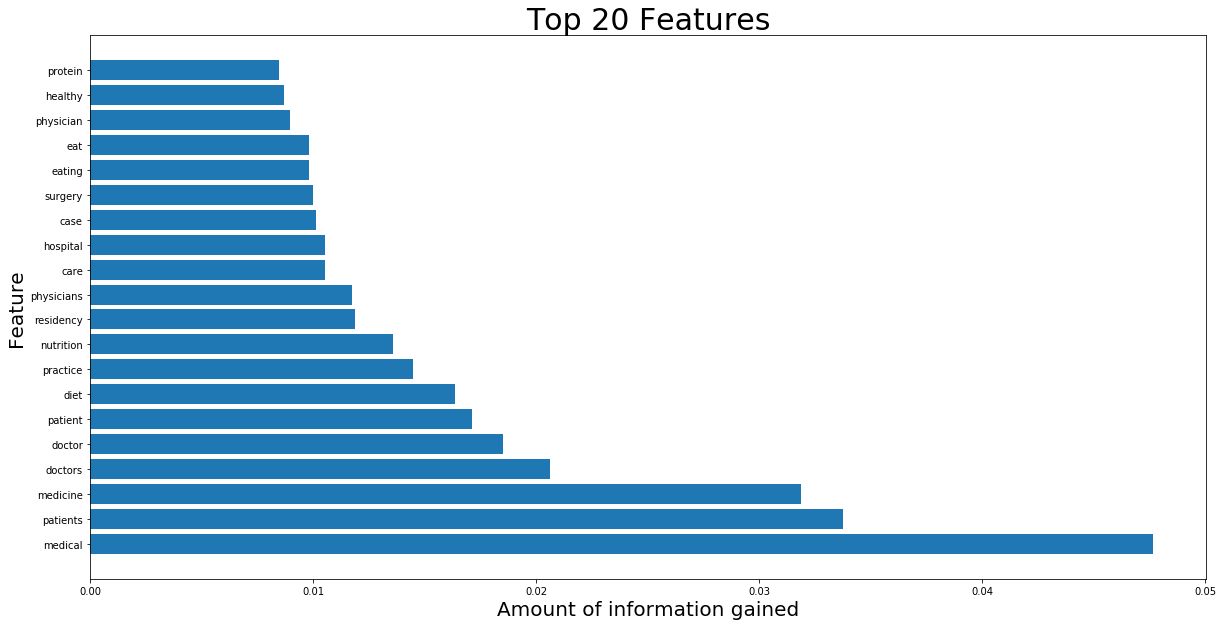

In [34]:
plt.figure(figsize=(20,10))
temp = feat_importance.sort_values('importance', ascending=False).head(20)
plt.barh(temp.index, temp['importance'])
plt.title('Top 20 Features', fontsize=30)
plt.xlabel('Amount of information gained', fontsize=20)
plt.ylabel('Feature', fontsize=20);

## Confusion Matrix and Classification Report

## Reddit NLP Random Forest model is complete

Proceed to the next notebook:
- [SubReddits_NLP_Naive_Bayes](03_SubReddits_NLP_Naive_Bayes.ipynb)